# Bernstein-Vazirani Algorithm
The Bernstein-Vazirani Algorithm is described in this document. The Bernstein-Vazirani Algorithm uses the same circuit as the Deutsch-Josza Algorithm to solve a different problem. We begin by importing the necessary components of qiskit and defining relevant circuit parameters.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit import Gate
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [2]:
# Define circuit parameters
a = [0, 1, 0, 1, 1]
n = len(a)

## Objective
We are given a subroutine that evaluates the following function on $n$ bit inputs

$$f(x) = a \cdot x = a_0x_0 \oplus a_1x_1 \oplus \cdots \oplus a_{n-1}x_{n-1}$$

Here, $a$ is an $n$ bit constant. Our objective is to identify $a$ with a minimum number of subroutine calls. Classicaly, this can be done by evaluating $f(x)$ at $x = 2^0, 2^1, \cdots 2^{n-1}$. This extracts out the individual bits of a in $n$ subroutine calls. The Bernstein-Vazirani Algorithm achieves the same using a single subroutine call in a quantum computer.

## Prerequisites
Before we describe the circuit for the Bernstein-Vazirani Algorithm, we shall need to develop a theorem that we will have the need to invoke, while describing the circuit operation. This is done in the following.

### Theorem 1
This theorem describes the action of a series of Hadamard Transforms on a series of qubits initialized to a general state $|x\rangle_n$. We claim that

$$H^{\otimes n}|x\rangle_n = \frac{1}{2^{n/2}} \sum_{y = 0}^{2^{n}-1} (-1)^{x \cdot y} |y\rangle_n$$

where
1. $H^{\otimes n}$ is the $H$ operator applied individually to each of the $n$ qubits.
2. $|x\rangle_n$ is a shorthand for the $n$ bit binary representation of $x$. For example, $|3\rangle_4 = |0011\rangle$
3. $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \cdots \oplus  x_{n-1}y_{n-1}$ (Bitwise AND, then XOR of all bits)

#### Proof
$$\begin{align*}
H^{\otimes n}|x\rangle_n &= H|x_0\rangle \otimes H|x_1\rangle \otimes \cdots \otimes H|x_{n-1}\rangle \\
&= \left(\frac{|0\rangle + (-1)^{x_0}|1\rangle}{\sqrt{2}}\right) \otimes \left(\frac{|0\rangle + (-1)^{x_1}|1\rangle}{\sqrt{2}}\right) \otimes \cdots \otimes \left(\frac{|0\rangle + (-1)^{x_{n-1}}|1\rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}}\left(\left(|0\rangle + (-1)^{x_0}|1\rangle\right) \otimes \left(|0\rangle + (-1)^{x_1}|1\rangle\right) \otimes \cdots \otimes \left(|0\rangle + (-1)^{x_{n-1}}|1\rangle\right) \right)
\end{align*}$$

Now, consider how we would multiply out the $\left(|0\rangle + (-1)^{x_i}|1\rangle\right)$ terms. We would choose either a $|0\rangle$ or a $|1\rangle$ from each of these $n$ terms and multiply (or really tensor product) with the rest of the terms to get one term of the the total expansion. The $|1\rangle$ terms come with an extra coefficient of $(-1)^{x_i}$. The final multiplied out sum will thus be the sum of all $n$ bit combinations of zeroes and ones; where each term has a $\pm 1$ coefficient. These terms are essentially all possible instances of $|y\rangle_n$. Thus, the final sum will be of the form

$$H^{\otimes n}|x\rangle_n = \frac{1}{2^{n/2}} \sum_{y = 0}^{2^{n}-1} c_y |y\rangle_n$$

where each $c_y = \pm 1$. Now, we must calculate $c_y$ for a given $y$. For a fixed $y$, $c_y$ is a product of terms of the form $(-1)^{x_i}$. If the $i^{th}$ bit $y_i$, of $y$, is $0$, $(-1)^{x_i}$ would not be multiplied into $c_y$ (since $(-1)^{x_i}$ only comes in when we select a $1$ for the $i^{th}$ bit). It would be included however, if $y_i = 1$. We can account for both these cases by just multiplying $(-1)^{x_iy_i}$ into $c_y$. Therefore, considering all bits, we get,

$$c_y = (-1)^{x_0y_0}(-1)^{x_1y_1} \cdots (-1)^{x_{n-1}y_{n-1}} = (-1)^{x \cdot y}$$

Thus, we get our final result,

$$H^{\otimes n}|x\rangle_n = \frac{1}{2^{n/2}} \sum_{y = 0}^{2^{n}-1} (-1)^{x \cdot y} |y\rangle_n$$

#### Corollary
For the special case when the input qubits are all initialized to $|0\rangle$, we get,

$$H^{\otimes n}|0\rangle = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n$$

## Circuit Description & Analysis
Now, we are finally in a position to describe the circuit for the Bernstein-Vazirani Algorithm.

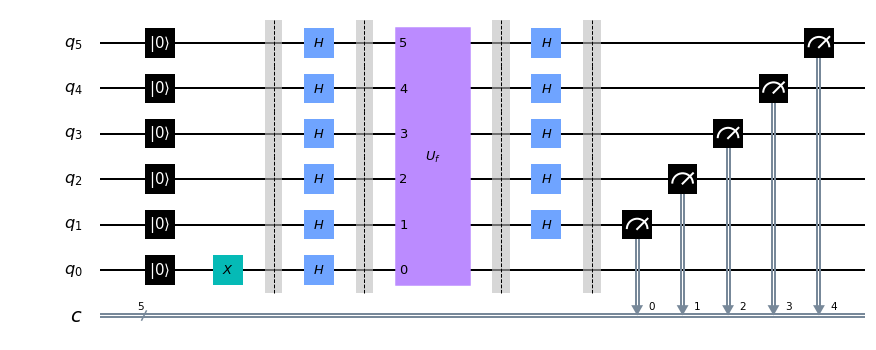

In [3]:
circ = QuantumCircuit(n+1, n)
circ.reset(range(n+1))
circ.x(0)
circ.barrier()
circ.h(range(n+1))
circ.barrier()
circ.append(Gate(name="$U_f$", num_qubits=n+1, params=[]), range(n+1))
circ.barrier()
circ.h(range(1, n+1))
circ.barrier()
circ.measure(range(1, n+1), range(n))
circ.draw('mpl', reverse_bits=True)

Here, the action of the $(n+1)$ qubit unitary operator $U_f$ is given by

$$U_f|xy\rangle = |x\rangle \otimes |y \oplus f(x)\rangle$$

where $x$ is an $n$ bit number and $y \in \{0,1\}$. In the above circuit, we have marked out 4 barriers. We shall describe the circuit operation by evaluating the quantum state of the qubits at these barriers, which we shall number 1-4 from left to right.

### Barrier 1
We initialize the $n$ qubit input register to zeros and the output qubit to 1. The state of the qubits is

$$|\psi_1\rangle = |0\rangle_n \otimes |1\rangle$$

### Barrier 2
We apply a chain of Hadamard Gates to the qubits. By the corollary to theorem 1 above, we get

$$\begin{align*}
|\psi_2\rangle &= H^{\otimes n}|0\rangle_n \otimes H|1\rangle \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes \left(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right)
\end{align*}$$

### Barrier 3
We apply the Unitary gate $U_f$ to the qubits. We get

$$\begin{align*}
|\psi_3\rangle &= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes \left(\frac{|0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} (-1)^{f(x)}|x\rangle_n \otimes \left(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} (-1)^{f(x)}|x\rangle_n \otimes H|1\rangle
\end{align*}$$

### Barrier 4
We apply a chain of Hadamard Gates to the $n$ qubit input register. From theorem 1 above, we get

$$\begin{align*}
|\psi_4\rangle &= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} (-1)^{f(x)}H^{\otimes n}|x\rangle_n \otimes H|1\rangle \\
&= \frac{1}{2^n} \sum_{x = 0}^{2^{n}-1} \sum_{y = 0}^{2^{n}-1} (-1)^{f(x)} (-1)^{x \cdot y}|y\rangle_n \otimes H|1\rangle \\
&= \frac{1}{2^n} \sum_{x = 0}^{2^{n}-1} \sum_{y = 0}^{2^{n}-1} (-1)^{f(x) \oplus x \cdot y}|y\rangle_n \otimes H|1\rangle
\end{align*}$$

### Measurement
We shall then measure the $n$ qubit input register. The probability of getting all of these $n$ bits to be $a$ is given by

$$\begin{align*}
P(a) &= \left|\frac{1}{2^n} \sum_{x = 0}^{2^{n}-1} \sum_{y = 0}^{2^{n}-1} (-1)^{f(x) \oplus x \cdot y}\langle a|y\rangle_n\right|^2 \\
&= \left|\frac{1}{2^n} \sum_{x = 0}^{2^{n}-1} (-1)^{a \cdot x \oplus a \cdot x}\right|^2 = 1
\end{align*}$$

Thus, a measurement of the input register now directly yields the value of $a$ for us.

## Qiskit Implementation
We will now implement the unitary operator $U_f$ required in the circuit. It is easily verified that this can be done via a series of CNOT gates that encode the value of $a$ as shown below.

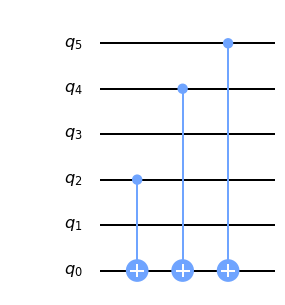

In [4]:
f = QuantumCircuit(n+1, name='f(x)')
for i in range (n):
    if a[i] == 1:
        f.cx(i+1,0)
f.draw('mpl', reverse_bits=True)

## State Vector Simulation
We simulate the Bernstein-Vazirani circuit using the state vector simulator. We plot the bloch multivectors for the final state. As expected, the final state of input register contains the value of $a$

In [5]:
circ = QuantumCircuit(n+1)
circ.x(0)
circ.barrier()
circ.h(range(n+1))
circ.append(f.to_instruction(), range(n+1))
circ.h(range(1, n+1))
circ.draw(reverse_bits=True, plot_barriers=False)

┌───┐┌───────┐┌───┐
q_5: ──────┤ H ├┤5      ├┤ H ├
           ├───┤│       │├───┤
q_4: ──────┤ H ├┤4      ├┤ H ├
           ├───┤│       │├───┤
q_3: ──────┤ H ├┤3      ├┤ H ├
           ├───┤│  f(x) │├───┤
q_2: ──────┤ H ├┤2      ├┤ H ├
           ├───┤│       │├───┤
q_1: ──────┤ H ├┤1      ├┤ H ├
     ┌───┐ ├───┤│       │└───┘
q_0: ┤ X ├─┤ H ├┤0      ├─────
     └───┘ └───┘└───────┘

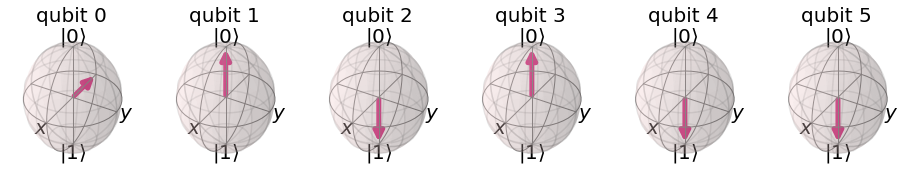

In [6]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(circ, simulator).result()
state = result.get_statevector()
plot_bloch_multivector(state)

## QASM Simulation
Finally, we shall verify that we always get the same answer for $a$ by using the QASM simulator.

In [7]:
circ = QuantumCircuit(n+1, n)
circ.x(0)
circ.barrier()
circ.h(range(n+1))
circ.append(f.to_instruction(), range(n+1))
circ.h(range(1, n+1))
circ.measure(range(1, n+1), range(n))
circ.draw(reverse_bits=True, plot_barriers=False)

┌───┐┌───────┐┌───┐            ┌─┐
q_5: ──────┤ H ├┤5      ├┤ H ├────────────┤M├
           ├───┤│       │├───┤         ┌─┐└╥┘
q_4: ──────┤ H ├┤4      ├┤ H ├─────────┤M├─╫─
           ├───┤│       │├───┤      ┌─┐└╥┘ ║ 
q_3: ──────┤ H ├┤3      ├┤ H ├──────┤M├─╫──╫─
           ├───┤│  f(x) │├───┤   ┌─┐└╥┘ ║  ║ 
q_2: ──────┤ H ├┤2      ├┤ H ├───┤M├─╫──╫──╫─
           ├───┤│       │├───┤┌─┐└╥┘ ║  ║  ║ 
q_1: ──────┤ H ├┤1      ├┤ H ├┤M├─╫──╫──╫──╫─
     ┌───┐ ├───┤│       │└───┘└╥┘ ║  ║  ║  ║ 
q_0: ┤ X ├─┤ H ├┤0      ├──────╫──╫──╫──╫──╫─
     └───┘ └───┘└───────┘      ║  ║  ║  ║  ║ 
c_4: ══════════════════════════╬══╬══╬══╬══╩═
                               ║  ║  ║  ║    
c_3: ══════════════════════════╬══╬══╬══╩════
                               ║  ║  ║       
c_2: ══════════════════════════╬══╬══╩═══════
                               ║  ║          
c_1: ══════════════════════════╬══╩══════════
                               ║             
c_0: ══════════════════════════╩═════════════

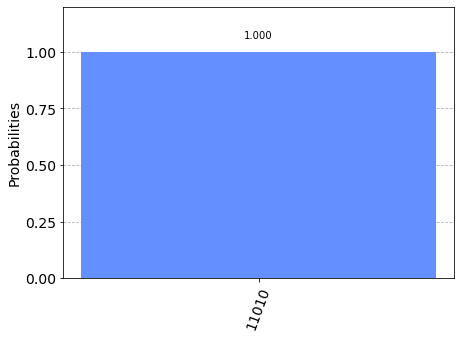

In [8]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circ, simulator, shots=1000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

## References
1. Bernstein, E., & Vazirani, U. (1993). Quantum complexity theory. Proceedings of the twenty-fifth annual ACM symposium on Theory of computing - STOC '93. https://doi.org/10.1145/167088.167097
2. Mermin, N. D. (2007). Quantum computer science: An introduction. Cambridge University Press.
3. Nielsen, M. A., & Chuang, I. L. (2010). Quantum computation and quantum information: 10th anniversary edition. Cambridge University Press.
4. Qiskit documentation — Qiskit 0.19.3 documentation. (n.d.). Qiskit. https://qiskit.org/documentation/